In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm
from tensorflow.python.client import device_lib


import os
import utilsProb
import utilsProbSS
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
import matplotlib
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import properscoring as ps

#mapping
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
importlib.reload(utilsProb)
importlib.reload(utilsProbSS)


<module 'utilsProbSS' from '/glade/work/wchapman/AnEn/CNN/Coastal_Points/utilsProbSS.py'>

## GPU setup 

In [4]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('available GPUs:',get_available_gpus())

os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points/')
#reloading utils after changes:
importlib.reload(utilsProbSS)

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


available GPUs: []


## Functions

In [14]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


def rmse(guess,truth):
    n = len(truth)
    rms = np.linalg.norm(guess - truth) / np.sqrt(n)
    return rms


def bias(guess,truth):
    bb = np.mean(guess)-np.mean(truth)
    return bb

def corrss(guess,truth):
    bb = np.corrcoef(np.squeeze(guess),np.squeeze(truth))[0,1]
    return bb


def crmse(guess,truth):
    guess = np.squeeze(guess)
    truth = np.squeeze(truth)
    mg = np.mean(guess)
    mt = np.mean(truth)
    n = len(truth)
    bb=np.linalg.norm((guess-mg) - (truth-mt)) / np.sqrt(n)
    return bb

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def spreadskill(guess,truth,stddevver,numbins):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    distPP = np.ndarray.flatten(stddevver)
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    
    indexsort = np.argsort(distPP)
    err = (guess- truth)**2
    varianceall = distPP[indexsort]
    err_sort = err[indexsort]

    numbins = numbins 
    inds = np.zeros(len(varianceall))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(varianceall)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
    
    avgvar_m = []
    msebin_m = []

    avgvar_s = []
    msebin_s = []
    nummy =2000

    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tavg =0
        tmse =0
        tavg = np.zeros(nummy)
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tavg[ii]  = np.mean(np.random.choice(varianceall[locbin],len(locbin)))
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        avgvar_m = np.append(avgvar_m,np.mean(tavg))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        avgvar_s = np.append(avgvar_s,np.std(tavg))
        msebin_s = np.append(msebin_s,np.std(tmse))
    return avgvar_m,msebin_m,avgvar_s,msebin_s

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 8))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype,name='banjo'),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1),name='banjo2'),
  ])


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype,name='spoon'),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1),name='doon'),
  ])



def stnd_error_mean(guess,truth,numbins):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    

    err = (guess- truth)**2
    indexsort = np.argsort(err)
    err_sort = err[indexsort]
    
    truthSORT = truth[indexsort]
    guessSORT = guess[indexsort]

    numbins = numbins 
    inds = np.zeros(len(err_sort))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(err_sort)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
        
    msebin_m = []
    msebin_s = []
    nummy =2000
    maxlist=[]
    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tmse =0
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        msebin_s = np.append(msebin_s,np.std(tmse))
        
        if bb == np.max(np.unique(inds)):
            print('...getting max...')
            mlt = truthSORT[locbin]
            mlg = guessSORT[locbin]
            mle = np.sqrt((truthSORT[locbin]-guessSORT[locbin])**2)
            
        
    return msebin_m,msebin_s,mlt,mlg,mle

#https://mran.microsoft.com/snapshot/2017-09-25/web/packages/scoringRules/vignettes/crpsformulas.html#Logistic

def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tfm.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)


def build_emb_model_bayes(n_features, n_outputs, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.0001,
                    loss=negloglik,
                    activation='relu', reg=None):
    """
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
    Returns:
        model: Keras model
    """
    net_in = tf.keras.layers.Input(shape=(n_features))
    id_in = tf.keras.layers.Input(shape=(1,))
    emb = tf.keras.layers.Embedding(max_id + 1, emb_size)(id_in)
    emb = tf.keras.layers.Flatten()(emb)
    Con = tf.keras.layers.Concatenate()([net_in, emb])
    D = tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")(Con)
    D = tfp.layers.DenseFlipout(10, activation="relu", name="dense_2")(D)
    D1 = tf.keras.layers.Dense(n_outputs)(D)
    D2 = tfp.layers.DistributionLambda(lambda t: tfd.Deterministic(loc=t,atol=0.2))(D1)
    model = tf.keras.models.Model(inputs = [net_in,id_in], outputs = D2)
    # Do inference.
    if compile:
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss=loss)
    model.summary()
    return model


def build_emb_model(n_features, n_outputs, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.0001,
                    loss=negloglik,
                    activation='relu', reg=None):
    """
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
    Returns:
        model: Keras model
    """
    net_in = tf.keras.layers.Input(shape=(n_features))
    id_in = tf.keras.layers.Input(shape=(1,))
    emb = tf.keras.layers.Embedding(max_id + 1, emb_size)(id_in)
    emb = tf.keras.layers.Flatten()(emb)
    Con = tf.keras.layers.Concatenate()([net_in, emb])
    D = tf.keras.layers.Dense(20,activation=tf.keras.layers.ReLU())(Con)
    D = tf.keras.layers.Dense(30,activation=tf.keras.layers.ReLU())(D)
    D1 = tf.keras.layers.Dense(n_outputs*2)(D)
    D2 = tfp.layers.DistributionLambda(lambda t: tfd.LogNormal(loc=t[..., :n_outputs],scale=1e-3 +tf.math.softplus(t[...,n_outputs:])))(D1)
    model = tf.keras.models.Model(inputs = [net_in,id_in], outputs = D2)
    # Do inference.
    if compile:
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss=loss)
    model.summary()
    return model


def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution."""
    m = np.exp(mu + sigma**2 / 2.0)
    v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return m, v


def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

## Time Step

In [6]:
stepnum=5

dd = '/glade/scratch/wchapman/Reforecast/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())

/glade/scratch/wchapman/Reforecast/F000
/glade/scratch/wchapman/Reforecast/F006
/glade/scratch/wchapman/Reforecast/F012
/glade/scratch/wchapman/Reforecast/F018
/glade/scratch/wchapman/Reforecast/F024


## Training/Testing/Validation Files

In [7]:
batch_num = 50
epochs = 30
#find all files in directory                                                                                                                                                  
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb.nc", recursive=True)])
for f in train_file_names:
    print(f)

print('Validating on')
validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb.nc", recursive=True)])
for f in validate_file_names:
    print(f)
    
print('Testing on')
test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb.nc", recursive=True)])
for f in test_file_names:
    print(f)
    
All_file_names =train_file_names[29:] + validate_file_names +test_file_names 

Training on
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1985_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1986_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1987_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1988_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1989_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1990_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1991_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1992_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1993_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1994_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1995_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1996_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1997_500mb.nc
/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1998_500mb.nc
/glade/scratch/wchapman/Reforecast/F

In [8]:
All_file_names

['/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2014_500mb.nc',
 '/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2015_500mb.nc',
 '/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2016_500mb.nc',
 '/glade/scratch/wchapman/Reforecast/F024/validate/F024_WY_2017_500mb.nc',
 '/glade/scratch/wchapman/Reforecast/F024/test/F024_WY_2018_500mb.nc']

## Check Region of Interest

...Searching...: /glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/
number of points: 153


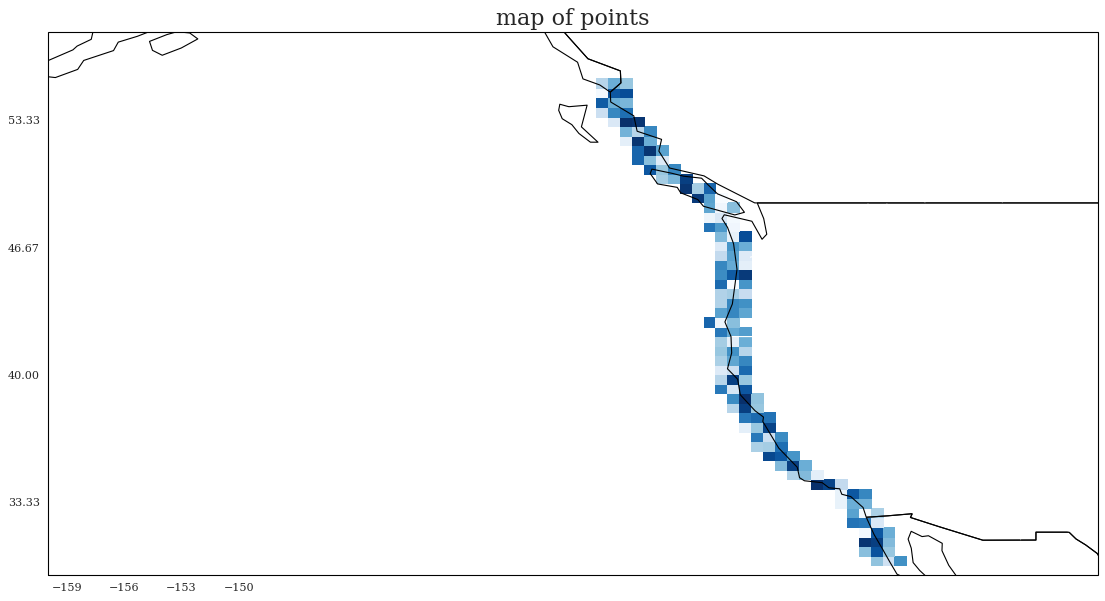

In [9]:
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
lat = np.arange(22,60.5,.5)
lon = np.arange(200.0,249.375+.625,.625)
MapPoints = np.zeros([lat.shape[0],lon.shape[0]])
print('...Searching...:',latlonfolder)
path = latlonfolder
pp_file_names = [f for f in glob.glob(path + "/lat*lon*", recursive=True)]
pp_file_names = sorted(pp_file_names)

for ff in pp_file_names:
    #find the appropriate lat/lon index
    ff2 = ff.split('lat')[1]
    ff3 = (ff2.split('lon'))
    latfind = float(ff3[0])
    lonfind = float(ff3[1])
    indlat= np.where(lat==latfind)[0][0]
    indlon= np.where(lon==lonfind)[0][0]
    MapPoints[indlat,indlon] = np.random.uniform()
    
MapPoints[MapPoints==0]=np.nan
print("number of points:", len(pp_file_names))

##################### plotting ###############################

fig = plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
cmap1 = matplotlib.cm.get_cmap("Blues",lut=55)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1,projection = proj)
ax.add_feature(cf.BORDERS)

ax.set_xticks(np.linspace(-180,-150, 11), crs=proj)
ax.set_yticks(np.linspace(20, 60, 7), crs=proj)
ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-160, -105, 29.5, 55])
scales = 1
ff = plt.pcolor(np.squeeze(lon),np.squeeze(lat),MapPoints,cmap=cmap1,vmin=0,vmax=scales)
plt.title('map of points',fontsize=20)

# savepath = dd + '/Map_of_points.pdf'
# plt.savefig(savepath , dpi=80)
plt.show()
# plt.close('all')

In [10]:
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind(latlonfolder)

In [11]:
rang = 153
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind(latlonfolder)
latsDO.shape
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])

norm_dict = utilsProbSS.get_image_normalization_params(train_file_names,latind,lonind)
sys.stdout.flush()
norm_dict_targ = utilsProbSS.get_image_normalization_params_targ(train_file_names,latind,lonind)
# sys.stdout.flush()
num_samps_train = utilsProb.count_samps(train_file_names)
num_samps_val = utilsProb.count_samps(validate_file_names)
num_samps_test = utilsProb.count_samps(test_file_names)

print('number of training samples:',num_samps_train)
# sys.stdout.flush()

print('number of validation samples:',num_samps_val)
# sys.stdout.flush()
print('number of validation samples:',num_samps_test)
num_samps_tot = num_samps_train+num_samps_val+num_samps_test

Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1985_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1986_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1987_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1988_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1989_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1990_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1991_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1992_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1993_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1994_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1995_5

/glade/work/wchapman/AnEn/CNN/Coastal_Points/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1987_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1988_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1989_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1990_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1991_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1992_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1993_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1994_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1995_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1996_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_1997_5

/glade/work/wchapman/AnEn/CNN/Coastal_Points/utilsProb.py:209: RuntimeWarning: divide by zero encountered in log
  predictor_matrix[:,:,:,indicesPRED] = numpy.log(predictor_matrix[:,:,:,indicesPRED])


Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2008_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2009_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2010_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2011_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2012_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2013_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2014_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2015_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2016_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/validate/F024_WY_2017_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/test/F024_WY_2018

In [78]:
All_file_names
boostnum = 500 #boost IVT overs this number. 

allinds = np.arange(len(All_file_names))

for bb in range(1,len(All_file_names)):
    allinds = np.arange(len(All_file_names))
    test_fil_name = [All_file_names[allinds[bb+1]]]
    val_fil_name = [All_file_names[allinds[bb]]]
    rest = np.delete(allinds,[bb,bb+1])
    train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('testing:',test_fil_name)
    print('validatiing:',val_fil_name)
    print('#################################################')
    
    num_samps_train = utilsProb.count_samps(train_fil_name)
    num_samps_val = utilsProb.count_samps(val_fil_name)

    print('...gathering data...')
    aa = utilsProbSS.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x = adf[0]
    y = adf[1]
    aa = utilsProbSS.deep_learning_generator_ss_mv(val_fil_name, num_samps_val*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x_tst = adf[0]
    y_tst = adf[1]

    #remove x and y where x ==0 
    rmind = np.where(utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
    print('before shape:',y.shape)
    print('deleting:',rmind[0].shape,'indices')
    x = np.delete(x,rmind[0],0)
    y = np.delete(y,rmind[0],0)
    print('after shape:',y.shape)
    
    rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)   
    
    
    print('y_tst:',y_tst.shape[0])
    print('x_tst:',x_tst.shape[0])
    
    print('...Encoding Stations...')

    SUMID = np.unique(x[:,6]+x[:,7])
    #station ID integers 
    stID = np.zeros([x.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x[:,6]+x[:,7]==un)
        stID[mats,:] = int(jj)
    stID=stID.astype(int)

    #station ID integers 
    stID_tst = np.zeros([x_tst.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x_tst[:,6]+x_tst[:,7]==un)
        stID_tst[mats,:] = int(jj)
    stID_tst=stID_tst.astype(int)
    print('...done...')


    x=x[:,:6]
    x_tst=x_tst[:,:6]
#     y_tst = y_tst+abs(np.min(y))+.013
#     y = y+abs(np.min(y))+1e-3+.013
#     y_tst[y_tst<0]=0
#     y_tst[y_tst==0]=1e-3
    break
    #train model
    

#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2016_500mb.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2015_500mb.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2014_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/validate/F024_WY_2017_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/test/F024_WY_2018_500mb.nc"...


/glade/work/wchapman/AnEn/CNN/Coastal_Points/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2015_500mb.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/validate/F024_WY_2017_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/test/F024_WY_2018_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2014_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F024/train/F024_WY_2015_500mb.nc"...
before shape: (55080, 1)
deleting: (0,) indices
after shape: (55080, 1)
before shape test: (18513, 1)
deleting test: (0,) indices
after shape tst: (18513, 1)
y_tst: 18513
x_tst: 18513
...Encoding Stations...
...done...


In [79]:
obs = np.squeeze((utilsProbSS.denormalize_images_targ(y,'IVT',norm_dict)))
WWRF = utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)


In [228]:
y_tst=(np.exp(y_tst))

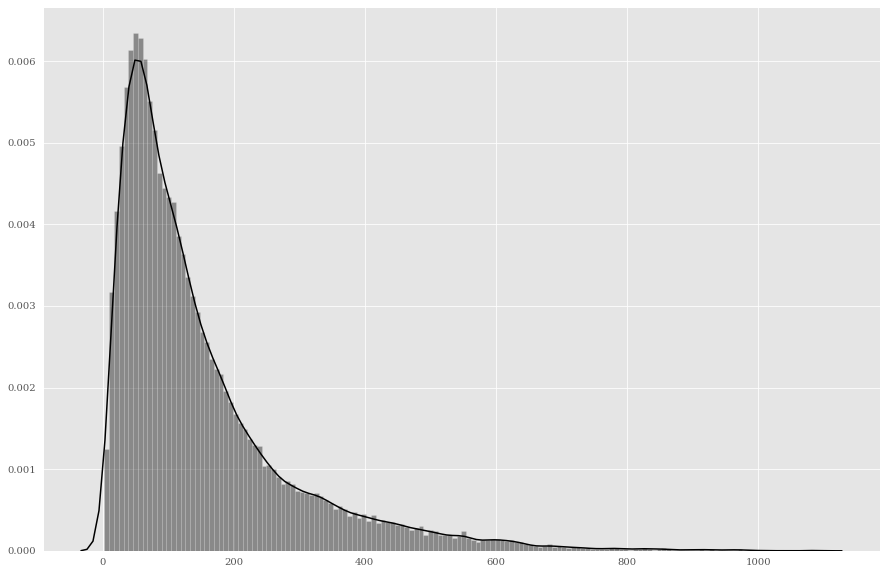

In [80]:
plt.figure(figsize=[15,10])  
sns.distplot(((obs)),150,color='k')
plt.show()

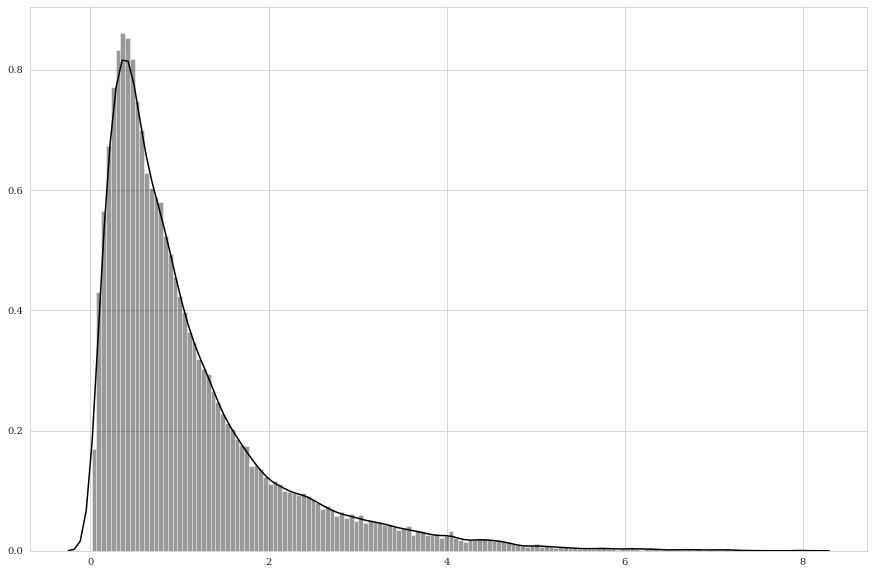

In [34]:
plt.figure(figsize=[15,10])  
sns.distplot(((y)),150,color='k')
plt.show()

<scipy.stats._continuous_distns.logistic_gen object at 0x2ac75812dda0> ____ 0.00013281277532114133
<scipy.stats._continuous_distns.invgauss_gen object at 0x2ac75811b198> ____ 1.6124294049811229e-06
<scipy.stats._continuous_distns.genextreme_gen object at 0x2ac7580ecda0> ____ 6.624669241505947e-06
<scipy.stats._continuous_distns.gumbel_l_gen object at 0x2ac7581113c8> ____ 0.0003210264923848501
<scipy.stats._continuous_distns.gumbel_r_gen object at 0x2ac758100da0> ____ 7.077188222135693e-05


Text(0, 0.5, 'Frequency')

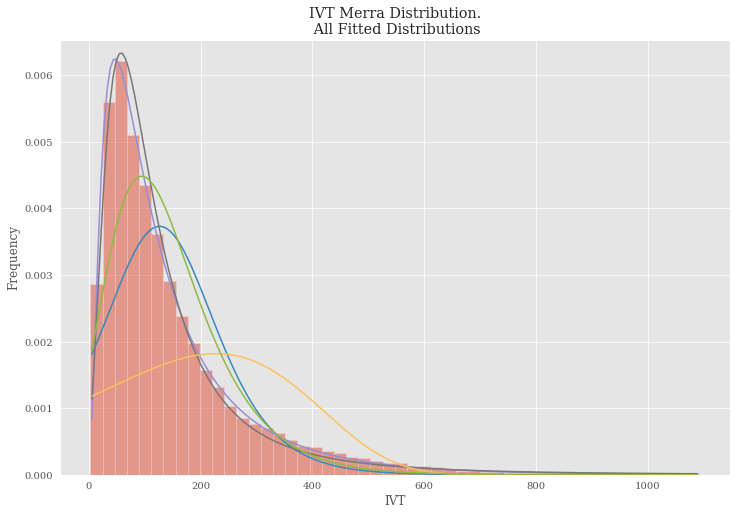

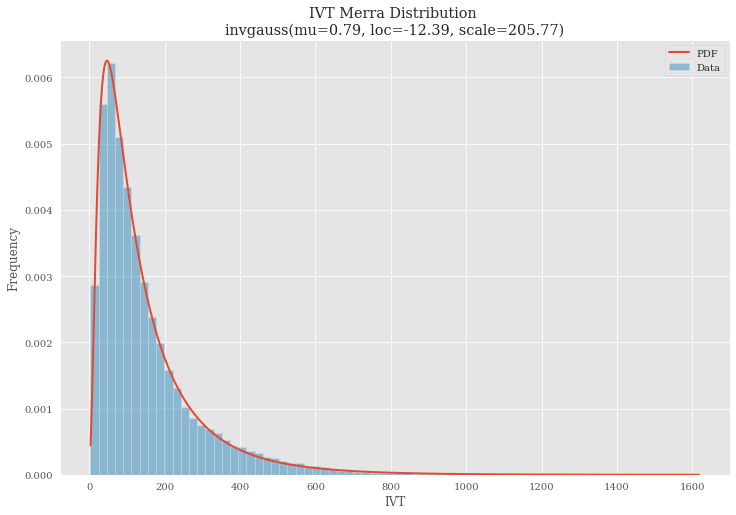

In [81]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        st.logistic,
#         st.norm,
#         st.lognorm,
        st.invgauss,
        st.genextreme,
        st.gumbel_l,
        st.gumbel_r,
#         st.weibull_min
#         st.norm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                print(distribution,'____',sse)
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.9999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(np.squeeze(obs))

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'IVT Merra Distribution.\n All Fitted Distributions')
ax.set_xlabel(u'IVT')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'IVT Merra Distribution \n' + dist_str)
ax.set_xlabel(u'IVT')
ax.set_ylabel('Frequency')

In [87]:
st.ks_2samp(np.squeeze(obs),x1)

Ks_2sampResult(statistic=0.005755265068990489, pvalue=0.3212685958792132)

In [85]:
x = st.logistic.rvs(0.07,0.56,obs.shape[0])
x1 = st.invgauss.rvs(0.79,scale=205.77,loc=-12.39,size=obs.shape[0])
# x2 = st.invgauss.rvs(0.66,loc=-22.0,scale=289.33,size=y_tst.shape[0])

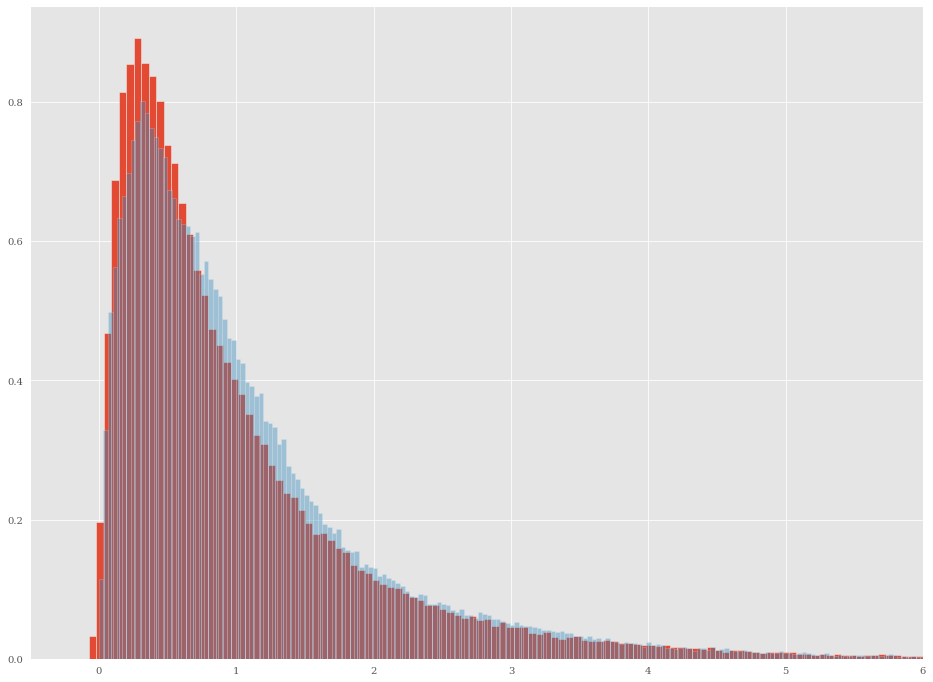

In [283]:
plt.hist(x1,300,density=True)
plt.hist(y,300,density=True,alpha=0.4)
plt.xlim([-0.5,6])
# plt.hist(x2,300,density=True)

plt.show()

Text(0, 0.5, 'Frequency')

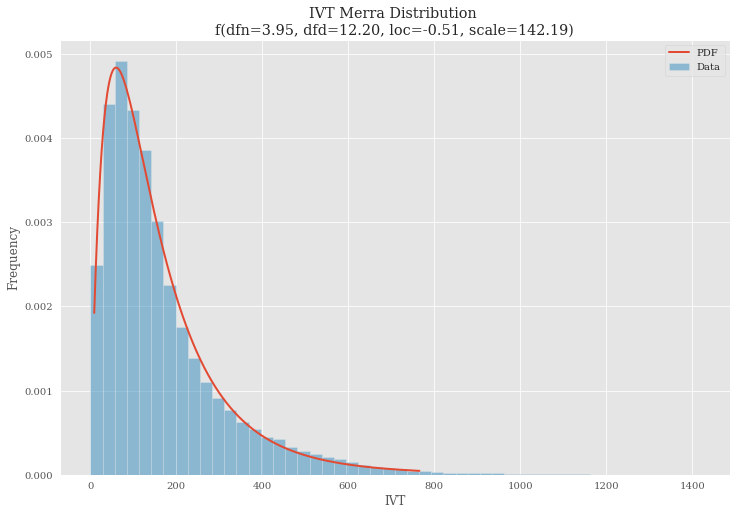

In [36]:
# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'IVT Merra Distribution \n' + dist_str)
ax.set_xlabel(u'IVT')
ax.set_ylabel('Frequency')

### Try Logistic Log-Likihood

In [24]:
in_shape = x.shape[1]
print('In shape: ',in_shape)
out_shape = 1
print('Out shape: ',out_shape)    
max_id = np.max(stID)
print('Number of Stations: ',max_id)    
epchs=50

model = build_emb_model(in_shape,out_shape,2,max_id ,compile=True)
valyr= val_fil_name[0].split('_500mb')[0]
valyr =valyr.split('_')[2]
    
tstyr= test_fil_name[0].split('_500mb')[0]
tstyr =tstyr.split('_')[2]
    
# #save location:
newdir = '/glade/scratch/wchapman/Reforecast/models/NN_Aleatoric/InvGauss/' +fcast+'/year_'+tstyr
if not os.path.exists(newdir):
    os.makedirs(newdir)
    
Wsave_name = newdir+'/cpf_NegLog_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    
print(Wsave_name)
modsave = tf.keras.callbacks.ModelCheckpoint(Wsave_name, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min',include_optimizer=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001,verbose=1)
er_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
net_in = tf.keras.layers.Input(shape=(in_shape))
    
#train model
histss = model.fit([x,stID], y,validation_data=([x_tst,stID_tst],y_tst), epochs=epchs,batch_size=batch_num ,verbose=1,callbacks=[modsave,reduce_lr]);
    
hist_df = pd.DataFrame(histss.history) 

In shape:  6
Out shape:  1
Number of Stations:  152
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         306         input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           embedding_1[0][0]                
________________________________________

In [27]:
m

array([3.168878 , 3.206691 , 3.0578058, ..., 1.4948313, 1.6159191,
       1.4347619], dtype=float32)

In [28]:
y_tst

array([[3.9099116],
       [3.8995645],
       [3.4843466],
       ...,
       [1.445144 ],
       [1.3770068],
       [1.2739029]], dtype=float32)

In [75]:
yhat.loc

<tf.Tensor: shape=(18513, 1), dtype=float32, numpy=
array([[1.1439493 ],
       [1.1558774 ],
       [1.1084744 ],
       ...,
       [0.37884492],
       [0.44619563],
       [0.32976028]], dtype=float32)>

In [73]:
yhat.mean().numpy()

array([[3.168878 ],
       [3.206691 ],
       [3.0578058],
       ...,
       [1.4948313],
       [1.6159191],
       [1.4347619]], dtype=float32)

In [45]:
yhat = model([x_tst,stID_tst])
m = np.squeeze(yhat.mean().numpy())
ss = np.squeeze(yhat.scale)
LOGstd = np.squeeze(yhat.stddev().numpy())

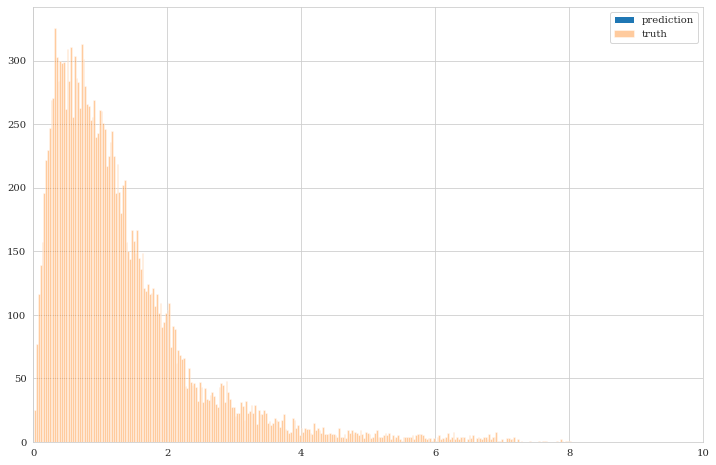

In [76]:
plt.figure(figsize=(12,8))
plt.hist((m ),300,label='prediction')
plt.hist((y_tst),300,label='truth',alpha=0.4)
plt.xlim([0,10])
plt.legend()
plt.show()

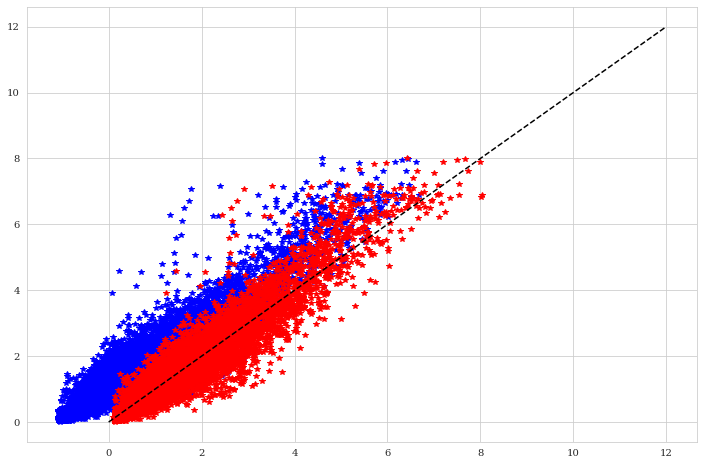

In [35]:
plt.figure(figsize=(12,8))

plt.plot((x_tst[:,0]),(y_tst),'*',color='blue')
plt.plot((m),(y_tst),'*',color='red')

plt.plot([0,12],[0,12],'k--')

In [44]:
np.log(m)

array([11.278044 , 11.286823 , 11.2518015, ..., 10.783134 , 10.828411 ,
       10.759889 ], dtype=float32)

In [47]:
obs = np.squeeze((utilsProbSS.denormalize_images_targ(y_tst,'IVT',norm_dict)))
WWRF = utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
m = (utilsProbSS.denormalize_images_targ(m,'IVT',norm_dict))

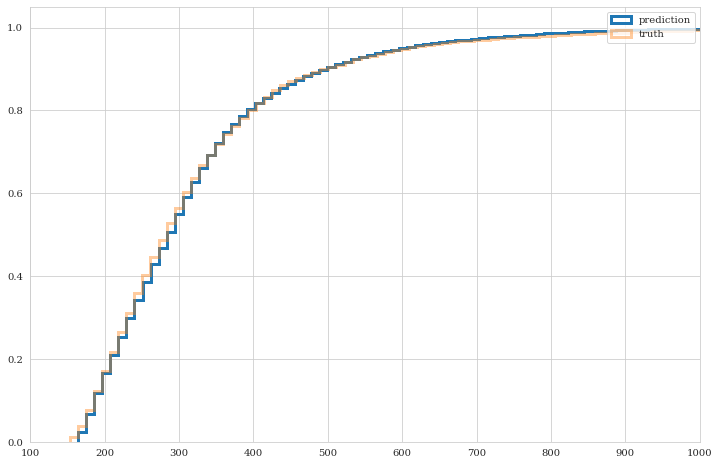

In [51]:
plt.figure(figsize=(12,8))

plt.hist((m),100,label='prediction',density=True, histtype='step',
                           cumulative=True,linewidth=3)
plt.hist(obs,100,label='truth',alpha=0.4,density=True, histtype='step',
                           cumulative=True,linewidth=3)
plt.xlim([100,1000])
plt.legend()
plt.show()

In [53]:
rmse(np.squeeze((m)),np.squeeze(obs))

46.804771388301894

In [107]:
rmse(np.squeeze(np.exp(WWRF)),np.squeeze(obs))

45.803809523398456

In [54]:
bias(np.squeeze((m)),np.squeeze(obs))

0.026977539

In [109]:
bias(np.squeeze(np.exp(WWRF)),np.squeeze(obs))

0.36154175

In [55]:
crmse(np.squeeze((m)),np.squeeze(obs))

46.80476062233843

In [111]:
crmse(np.squeeze(np.exp(WWRF)),np.squeeze(obs))

45.80238123891153

In [112]:
np.exp(y_tst)

array([[0.1295801 ],
       [0.13759376],
       [0.06987662],
       ...,
       [2.830737  ],
       [2.5089722 ],
       [1.9142315 ]], dtype=float32)

In [56]:
def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

In [60]:
ens = np.zeros([21,m.shape[0]])
for bb in range(m.shape[0]):
    temp = np.random.lognormal(mean=(m[bb]),sigma=ss[bb],size=21)
#     temp = utilsProbSS.denormalize_images_targ(temp,'IVT',norm_dict)
    ens[:,bb]= (temp)
obs = np.squeeze((utilsProbSS.denormalize_images_targ(y_tst,'IVT',norm_dict)))
rr=ranker(obs,ens)

In [64]:
rr = obs

array([681.80035, 680.3953 , 624.01483, ..., 347.12103, 337.86896,
       323.869  ], dtype=float32)

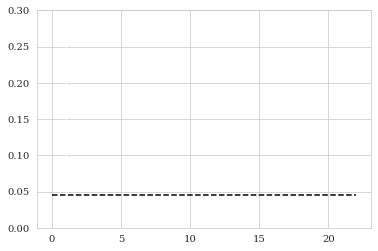

In [62]:
plt.hist(rr,22,density=True)
plt.plot([0,22],[0.045,0.045],'k--')
plt.ylim([0,.3])
plt.show()

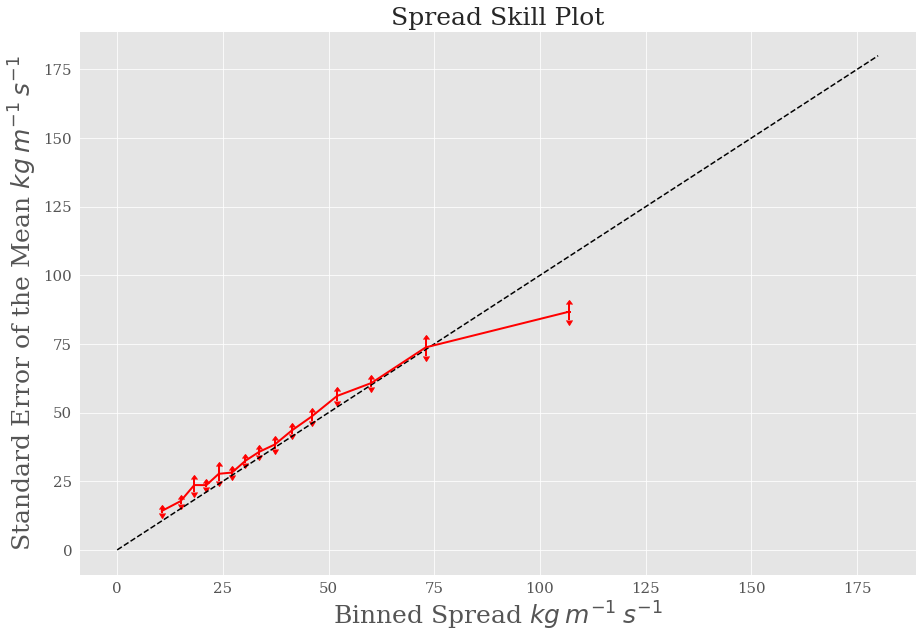

In [117]:
distSS=np.std(ens,axis=0)
[avgvar_m,msebin_m,avgvar_s,msebin_s]=spreadskill(np.exp(m),obs,distSS,15)
plt.figure(figsize=[15,10])  # inches
plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color='r',linewidth=2)
plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Spread Skill Plot',fontsize=25)

plt.plot([0,180],[0,180],'k--')
plt.show()

In [119]:
def neg_log_likelihood(y_obs, y_pred, sigma=1):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return tf.keras.backend.sum(-dist.log_prob(y_obs))

In [132]:
model_bayes.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_8 (DenseVa multiple                  420       
_________________________________________________________________
dense_variational_9 (DenseVa multiple                  1260      
_________________________________________________________________
dense_variational_10 (DenseV multiple                  63        
Total params: 1,743
Trainable params: 1,743
Non-trainable params: 0
_________________________________________________________________


In [134]:
batchnum =128
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

model_bayes = tf.keras.Sequential([
    tfp.layers.DenseFlipout(10, activation="relu", name="dense_1"),
    tfp.layers.DenseFlipout(10, activation="relu", name="dense_2"),
    tfp.layers.DenseFlipout(1, activation="relu", name="dense_3"),
])

In [135]:
model_bayes.compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(lr=0.08), metrics=['mse'])
# model_bayes.fit(np.expand_dims(x[:,0],axis=1),y, batch_size=40, epochs=100, verbose=1);

Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


AttributeError: 'Tensor' object has no attribute 'log_prob'

In [136]:
#https://brendanhasz.github.io/2018/12/03/tfp-regression

In [128]:
model_bayes.predict(x_tst)

array([[-0.00790992],
       [-0.00790992],
       [-0.00790992],
       ...,
       [-0.00715162],
       [-0.00715162],
       [-0.00715162]], dtype=float32)

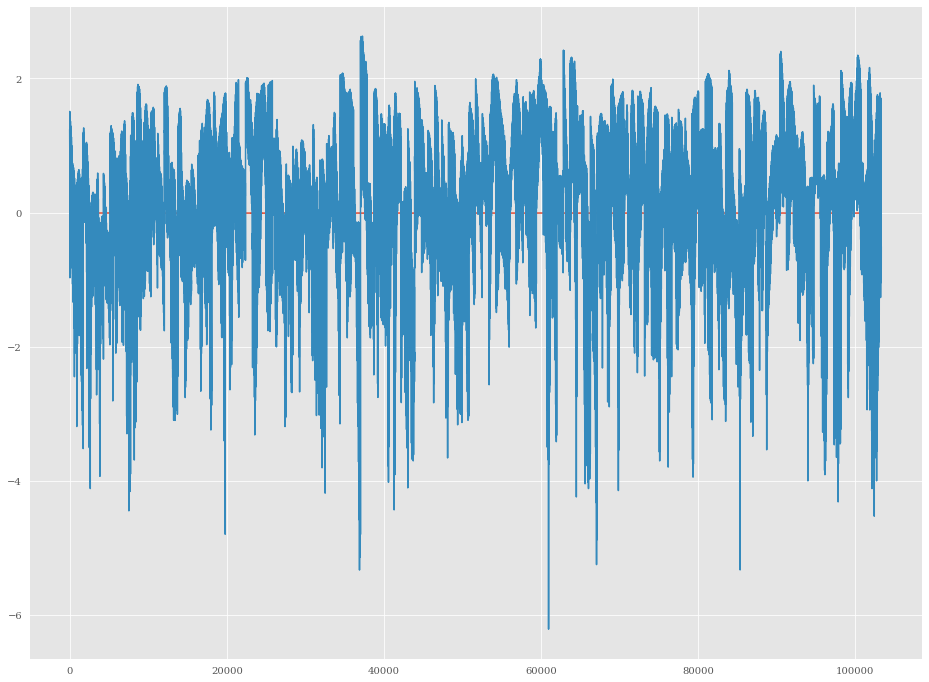

In [130]:
plt.plot(model_bayes.predict(x_tst))
plt.plot(y_tst)

In [106]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])